# SAY SOSMETHING HERE


 Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market.
 
- Build a price prediction model similarly to how we did in our case study for London.
- Discuss your modeling decisions and compare your results to those of the case study.

In [1]:
#@ least 3 different models: (I have to argue for my choice of models)

#Model 1: OLS Linear Regression
#Model 2: LASSO 
#Model 3: Regression Tree (CART)
#Model 4: Random Forest(RF)

### Importing Libraries

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

### Reading Data & Exploratory Data Analysis

In [3]:
data = pd.read_csv('austinairbnblistings.csv')

In [4]:
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,2,668,2023-11-20,3.71,1,330,47,NaN
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,NaN,1,294,2023-12-07,1.76,1,0,20,NaN
2,218402,Home in Austin · ★4.74 · 1 bedroom · 1 bed · 1...,1129520,Paulette,NaN,78754,30.36145,-97.64397,Private room,30.0,28,29,2023-09-24,0.20,1,252,2,NaN


In [5]:
data.shape

(15419, 18)

In [6]:
data = data.loc[data['room_type'] == 'Entire home/apt']

In [7]:
in_depth_data = pd.read_csv('indepthaustinairbnb.csv')

In [8]:
in_depth_data.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,5769,https://www.airbnb.com/rooms/5769,20231215200307,2023-12-16,previous scrape,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.76,4.92,NaN,f,1,0,1,0,1.76
2,6413,https://www.airbnb.com/rooms/6413,20231215200307,2023-12-16,previous scrape,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70


In [9]:
in_depth_data = in_depth_data.loc[(in_depth_data['accommodates'] >=2) & (in_depth_data['accommodates'] <=6) ]

In [10]:
in_depth_data.accommodates.value_counts()

accommodates
2    3964
4    3340
6    2293
3    1047
5     837
Name: count, dtype: int64

In [11]:
#created new df airbnb (combines both previous data frames)
airbnb = pd.merge(data, in_depth_data, on = 'id')

In [12]:
airbnb.head(3)

,id,name_x,host_id_x,host_name_x,neighbourhood_group,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,...,review_scores_communication,review_scores_location,review_scores_value,license_y,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month_y
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,NaN,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70
2,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159.0,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09


In [13]:
airbnb.rename(columns = {'price_x':'price'}, inplace = True)

In [15]:
airbnb['bathrooms'] = airbnb['bathrooms_text'].apply(lambda x: float(x.split()[0]) if x.split()[0].replace('.', '').isdigit() else None)
#turned observations into floats 

In [16]:
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
#turned observations into booleans

In [17]:
airbnb.maximum_nights

0         90
1         90
2        365
3         60
4         90
        ... 
9343    1125
9344     365
9345     365
9346     365
9347     365
Name: maximum_nights, Length: 9348, dtype: int64

In [18]:
#ONLY FOR OLS LINEAR REGRESSION (doing variable selection and interaction selection only for linear regression)
#my other models will have variables chosen on their own due to algorithms!!!
# y = price
# x = bathrooms, beds, review_scores_rating, property_type, availability_365_x, 
#number_of_reviews, host_is_superhost, minimum_nights_y, maximum_nights,
# interaction terms: (before doing these for sure, do scatterplot to see their correlation) bathrooms*beds, 
# maximum_nights*minimum_nights, availability*number_of_reviews 

In [45]:
#must drop any null values in outcome variable (price)
airbnb.price.isnull().sum()
airbnb.dropna(subset = ['price'], inplace = True)

#bathroom observations already turned into floats. now dropping null bathrooms (only 3)
airbnb.bathrooms.isnull().sum()
airbnb.dropna(subset = ['bathrooms'], inplace = True)

#beds. dropping null beds (only 43)
airbnb.beds.isnull().sum()
airbnb.dropna(subset = ['beds'], inplace = True)

#review_scores_rating. over 1000 null values. will impute with median as distribution looks far 
#from normal (used ggplot to plot distribution). will also create flagged variable for missing review_scores_rating
#and flag variable for imputed review_scores_rating
airbnb.review_scores_rating.isnull().sum()
airbnb['missing_review_scores_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb['review_scores_imputed_flag'] = airbnb.review_scores_rating.isnull().astype(int)
airbnb.fillna({'review_scores_rating': airbnb['review_scores_rating'].median()}, inplace=True)

#property type. creating dummy variables (main property types: entire home, entire rental unit, entire condo, 
#entire guesthouse, entire guest suite, entire townhouse, others)
airbnb.property_type.value_counts()
airbnb['entire_home'] = (airbnb['property_type'] == 'Entire home').astype(int)
airbnb['entire_rental_unit'] = (airbnb['property_type'] == 'Entire rental unit').astype(int)
airbnb['entire_condo'] = (airbnb['property_type'] == 'Entire condo').astype(int)
airbnb['entire_guesthouse'] = (airbnb['property_type'] == 'Entire guesthouse').astype(int)
airbnb['entire_guest_suite'] = (airbnb['property_type'] == 'Entire guest suite').astype(int)
airbnb['entire_townhouse'] = (airbnb['property_type'] == 'Entire townhouse').astype(int)
property_types_exclude = ['Entire home', 'Entire rental unit', 'Entire condo', 'Entire guesthouse', 'Entire guest suite', 'Entire townhouse']
airbnb['entire_other_property_type'] = (~airbnb['property_type'].isin(property_types_exclude)).astype(int)

#availability_365_x has no null values and is int. no data work needed
airbnb.availability_365_x.isnull().sum()

#number_of_reviews_x has no null values and is int. no data work needed
airbnb.number_of_reviews_x.isnull().sum()

#host_is_superhost. already dummy variable. no data work needed
airbnb.host_is_superhost

#minimum_nights_y has no null values and is int. no data work needed
airbnb.minimum_nights_y.isnull().sum()

#maximum_nights has no null values and is int. no data work needed
airbnb.maximum_nights.isnull().sum()


0

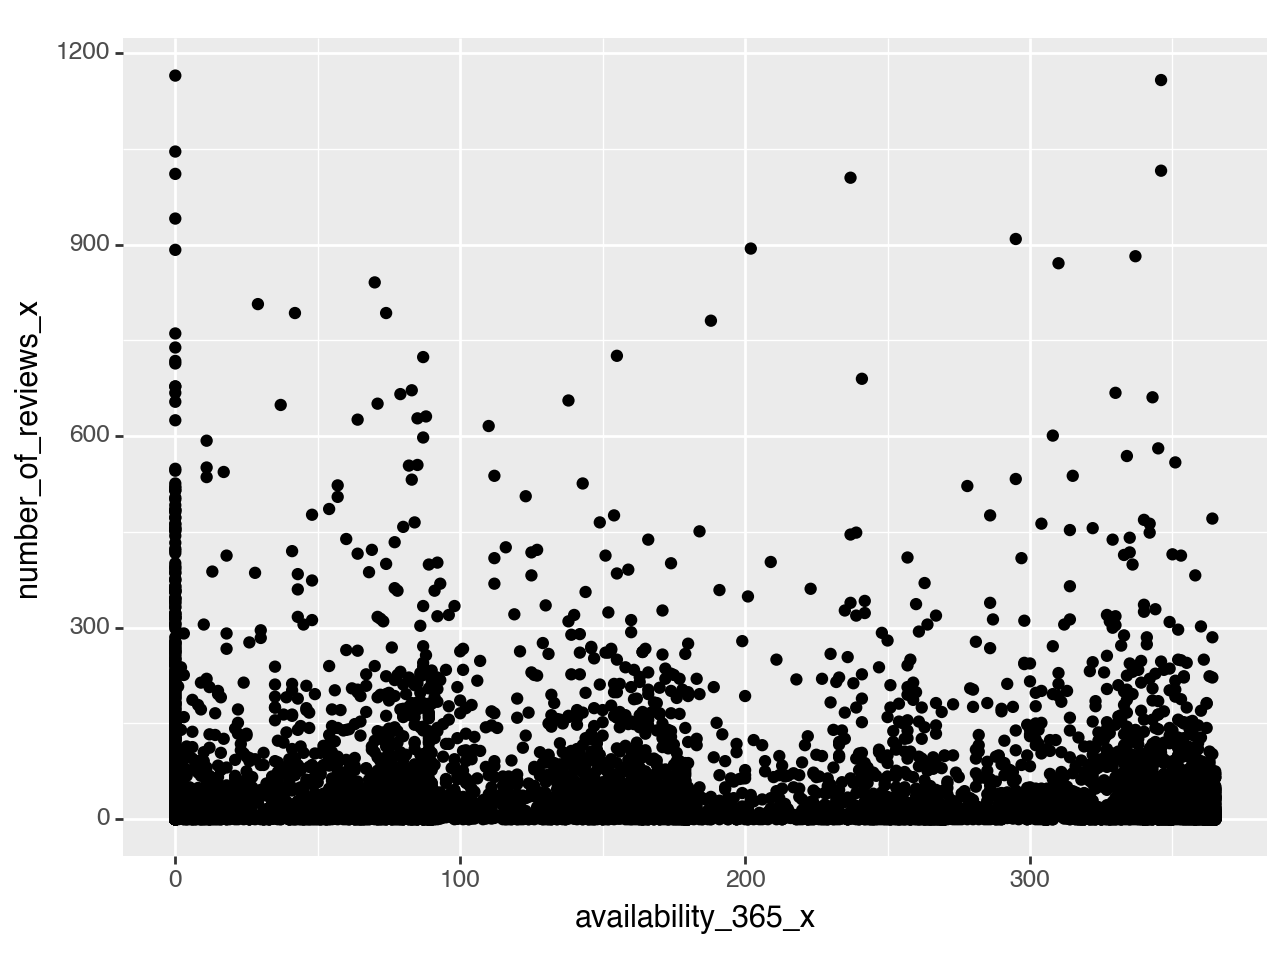

<Figure Size: (640 x 480)>

In [50]:
#had the idea to include interactions but after plotting some interaction terms together in a scatterplot, I didn't
#find much correlation for the interactions I was looking at (ex. bathrooms*beds, 
#maximum_nights*minimum_nights, availability*number_of_reviews)

ggplot(airbnb, aes(x = 'availability_365_x', y = 'number_of_reviews_x')) + geom_point()

### Model 1: OLS Linear Regression

In [52]:
reg1 = (smf.ols(formula='''price~bathrooms+ beds+ review_scores_rating+ entire_home+ 
entire_rental_unit+ entire_condo+ entire_guesthouse+ entire_guest_suite+ 
entire_townhouse+availability_365_x+number_of_reviews_x+host_is_superhost+ minimum_nights_y
+maximum_nights''', data=airbnb).fit(cov_type="HC1"))
#entire_other_property_type is the reference category for all the other 'entire' property types listed
#not being a superhost is the refererence category for host_is_superhost
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     34.22
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           2.82e-90
Time:                        14:02:48   Log-Likelihood:                -60098.
No. Observations:                7476   AIC:                         1.202e+05
Df Residuals:                    7461   BIC:                         1.203e+05
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              529.9150 

In [53]:
#data_train, data_holdout = train_test_split(airbnb, train_size=0.7, random_state=42)

In [54]:
#data_train.shape, data_holdout.shape

((5233, 101), (2243, 101))

In [69]:
#X = list of the predictor variables
selected_features = ['bathrooms', 'beds', 'review_scores_rating', 'entire_home', 'entire_rental_unit', 'entire_condo',
    'entire_guesthouse' , 'entire_guest_suite' , 'entire_townhouse' , 'availability_365_x' , 'number_of_reviews_x' ,
    'host_is_superhost' , 'minimum_nights_y' , 'maximum_nights']

X = airbnb[selected_features]
# y = outcome variable
y = airbnb['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#standardizing the features for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LASSO regression model
lasso_model = Lasso(alpha=0.1) 

#fitting LASSO model on training set
lasso_model.fit(X_train_scaled, y_train)

#prediction on test set
y_pred = lasso_model.predict(X_test_scaled)

#calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

#coefficients of model
coefficients = pd.Series(lasso_model.coef_, index=X.columns)
print("LASSO Coefficients:")
print(coefficients)


RMSE: 703.5624895487822
LASSO Coefficients:
bathrooms               43.192301
beds                     5.274556
review_scores_rating   -22.026305
entire_home            -11.673070
entire_rental_unit      37.097949
entire_condo           -18.651811
entire_guesthouse       -6.520672
entire_guest_suite      -4.422531
entire_townhouse        -9.580531
availability_365_x      70.890045
number_of_reviews_x    -15.659667
host_is_superhost      -41.902810
minimum_nights_y         2.089816
maximum_nights         -27.947930
dtype: float64
